<a href="https://colab.research.google.com/github/Andron00e/CBM_Optim/blob/main/initial_concepts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/huggingface/peft.git git+https://github.com/huggingface/transformers.git
!pip install accelerate
!pip install bitsandbytes
!pip install sentencepiece
!pip install datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.4/492.4 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.3 MB/s eta 0:00:00
     ━━━

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch.nn as nn
import bitsandbytes as bnb

# Processing dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset("cifar10")

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [ ]:
print(dataset["train"]["label"][:5])
print(dataset["test"]["label"][:5])

[0, 6, 0, 2, 7]
[3, 8, 8, 0, 6]


In [5]:
label_dict = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}
list_of_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
label_dict[6]

'frog'

In [ ]:
new_train_label = []
for i in dataset["train"]["label"]:
  new_train_label.append(label_dict[i])

new_test_label = []
for i in dataset["test"]["label"]:
  new_test_label.append(label_dict[i])

print(new_train_label[:5])
print(new_test_label[:5])

dataset["train"] = dataset["train"].add_column("new_train_label", new_train_label)
dataset["test"] = dataset["test"].add_column("new_test_label", new_test_label)
dataset["train"] = dataset["train"].remove_columns("label")
dataset["test"] = dataset["test"].remove_columns("label")
dataset["train"] = dataset["train"].rename_column("new_train_label", "label")
dataset["test"] = dataset["test"].rename_column("new_test_label", "label")

dataset

['airplane', 'frog', 'airplane', 'bird', 'horse']
['cat', 'ship', 'ship', 'airplane', 'frog']


DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [ ]:
dataset["train"]["label"][:5]

['airplane', 'frog', 'airplane', 'bird', 'horse']

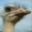

In [ ]:
dataset["train"]["img"][7]

# Loading model LLama 2 for generation concepts



In [6]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
torch.cuda.empty_cache()

In [7]:
from transformers import AutoTokenizer, AutoModelForCausalLM


model = AutoModelForCausalLM.from_pretrained(
    "TheBloke/Llama-2-7B-Chat-fp16",
    torch_dtype=torch.float16,
    load_in_8bit=True,
    device_map='auto'
)
tokenizer = AutoTokenizer.from_pretrained("TheBloke/Llama-2-7B-Chat-fp16")
tokenizer.pad_token_id = (
    0
)
tokenizer.padding_side = "left"

print(model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear8bitLt(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSN

In [9]:
from transformers import pipeline

pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=AutoTokenizer.from_pretrained("TheBloke/Llama-2-7B-Chat-fp16"),
    torch_dtype=torch.float16,
    device_map="auto",
    do_sample=True,
    top_k=10,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
    max_length=200
)
for label in list_of_labels:

    prompt = f"List the most important features for recognizing something as a {label}?" # , max_length=50, do_sample=True, temperature=0.7
    generated = pipeline(prompt)[0]['generated_text']
    print(f"Q1: {prompt}\nA1: {generated}\n")

    prompt = f"List the things most commonly seen around a {label}"
    generated = pipeline(prompt)[0]['generated_text']
    print(f"Q2: {prompt}\nA2: {generated}\n")

    prompt = f"Give a generalization for the word {label}"
    generated = pipeline(prompt)[0]['generated_text']
    print(f"Q3: {prompt}\nA3: {generated}\n")

Q1: List the most important features for recognizing something as a airplane?
A1: List the most important features for recognizing something as a airplane?

Here are some possible features:

1. Wings: Airplanes have wings, which are flat, horizontal surfaces that provide lift during flight.
2. Engines: Airplanes are powered by engines, which are typically located on the wings or fuselage.
3. Fuselage: The fuselage is the main body of the airplane, which contains the cockpit, passengers, and cargo.
4. Control surfaces: Airplanes have control surfaces, such as ailerons, elevators, and rudders, which are used to control the airplane during flight.
5. Landing gear: Airplanes have landing gear, which includes wheels, struts, or other structures that support the airplane during takeoff, landing, and taxiing.
6. Cockpit: The cockpit is the

Q2: List the things most commonly seen around a airplane
A2: List the things most commonly seen around a airplane cockpit.

This information may be useful

In [15]:
from transformers import pipeline

pipeline_test = pipeline(
    "text-generation",
    model=model,
    tokenizer=AutoTokenizer.from_pretrained("TheBloke/Llama-2-7B-Chat-fp16"),
    torch_dtype=torch.float16,
    device_map="auto",
    do_sample=True,
    top_k=10,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
    max_length=200
)
for label in list_of_labels:

    prompt = f"Give a universalization for the word {label}"
    generated = pipeline_test(prompt)[0]['generated_text']
    print(f"Q3: {prompt}\nA3: {generated}\n")

Q3: Give a universalization for the word airplane
A3: Give a universalization for the word airplane.

Answer:

An airplane is a vehicle that is used for transportation, typically by flying through the air. It is made up of a fuselage, wings, and engines, and is designed to transport people or cargo. Airplanes are used for a variety of purposes, including commercial flights, military operations, and personal travel.










Q3: Give a universalization for the word automobile
A3: Give a universalization for the word automobile. A universal has been provided below.

Automobile Universalization

Automobile refers to a vehicle that is designed to transport people or goods on roads. It can be a car, truck, bus, or any other motorized vehicle. Automobiles are an essential part of modern life, providing an efficient means of transportation and contributing to economic development.
In many societies, automobiles are a status symbol, with luxury vehicles signifying wealth and success. However,

# Concept set filtering